# Performance on simulated electrons and photons

In [1]:
%load_ext autoreload
%autoreload 2

import math
from itertools import product
import uproot
import awkward
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import binned_statistic

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

from calo_likelihood import caloLikelihood
from general_functions import *
from loaders import *
from initializers import initialisation_for_calorimetry_shower

In [2]:
today = 'calorimetry_trial'

In [3]:
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/shower_calo/base_plots/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/shower_calo/pdfs/plane0/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/shower_calo/pdfs/plane1/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/shower_calo/pdfs/plane2/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/shower_calo/performance_plots/
save_folder = '/home/nic/Dropbox/MicroBooNE/_fig/' + today + '/shower_calo/'
save_folder_base = save_folder + 'base_plots/'
save_folder_pdfs = save_folder + 'pdfs/'
save_folder_performance = save_folder + 'performance_plots/'

## Loading and initializing

In [4]:
branches = [
    'run',
    'sub',
    'evt',
    
    'generation',
    'backtracked_pdg',
    'backtracked_e',
    'backtracked_purity',
    'backtracked_completeness',
    'backtracked_overlay_purity',
    'backtracked_start_x',
    'backtracked_start_y',
    'backtracked_start_z',
    'backtracked_start_t',
    'backtracked_sce_start_x',
    'backtracked_sce_start_y',
    'backtracked_sce_start_z',
    
    'nplanehits_U',
    'nplanehits_V',
    'nplanehits_Y',
    'trk_score',

    'trk_start_x',
    'trk_start_y',
    'trk_start_z',
    
    'trk_sce_start_x',
    'trk_sce_start_y',
    'trk_sce_start_z',

    'trk_end_x',
    'trk_end_y',
    'trk_end_z',
    
    'trk_sce_end_x',
    'trk_sce_end_y',
    'trk_sce_end_z',
    
    'trk_theta',
    'trk_phi',

    'trk_dir_x',
    'trk_dir_y',
    'trk_dir_z',

    'trk_len',
    
#     'dqdx_u',
#     'dqdx_v',
#     'dqdx_y',

    'dedx_u',
    'dedx_v',
    'dedx_y',

    'rr_u',
    'rr_v',
    'rr_y',

    'pitch_u',
    'pitch_v',
    'pitch_y',
    
    'x_u',
    'x_v',
    'x_y',
    
    'y_u',
    'y_v',
    'y_y',
    
    'z_u',
    'z_v',
    'z_y',
    
    'dir_x_u',
    'dir_x_v',
    'dir_x_y',
    
    'dir_y_u',
    'dir_y_v',
    'dir_y_y',
    
    'dir_z_u',
    'dir_z_v',
    'dir_z_y',
]

In [5]:
# Declaring files, folder and tree

directory = '~/Desktop/MicroBooNE/calorimetry_likelihood/v05/'

folder = "nuselection"
tree = "CalorimetryAnalyzer"

split_factor = 0.2
split_factor2 = 0.22

file_lists = {}
arrays_train = {}
arrays_test = {}

file_lists['nue'] = directory + 'bnb_nue_shr/out.root'
file_lists['ccpi0'] = directory + 'bnb_ccpi0_shr/out.root'
file_lists['ncpi0'] = directory + 'bnb_ncpi0_shr/out.root'

In [6]:
#Loading arrays
for name, file_path in file_lists.items():
    root_file = uproot.open(file_path)[folder][tree]
    entry_split = int(len(root_file) * split_factor)
    entry_split2 = int(len(root_file) * split_factor2)
    arrays_train[name] = root_file.arrays(branches, namedecode="utf-8", entrystop=entry_split)
    arrays_test[name] = root_file.arrays(branches, namedecode="utf-8", entrystart=entry_split, entrystop=entry_split2)

In [7]:
# Merging nue, nu, and ncpi0
array_train = {}
array_test = {}
for variable in branches:
    array_train[variable] = awkward.concatenate([array[variable] for array in arrays_train.values()])    
    array_test[variable] = awkward.concatenate([array[variable] for array in arrays_test.values()])

In [8]:
# initialising arrays
for array in [array_train, array_test]:
    initialisation_for_calorimetry_shower(array)

/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/general_functions.py:93: RuntimeWarning: overflow encountered in square
  array[name_out] = np.sqrt( (point1_x - point2_x)**2 +
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/general_functions.py:94: RuntimeWarning: overflow encountered in square
  (point1_y - point2_y)**2 +
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/general_functions.py:95: RuntimeWarning: overflow encountered in square
  (point1_z - point2_z)**2 )
/home/nic/.local/lib/python3.8/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.8/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
def selection_for_train(array):
    return (array['backtracked_purity'] > 0.9) &\
           (array['start_is_fiducial']) &\
           (array['distance_3d_start'] < 2) &\
           (array['distance_3d_start'] > 0) &\
           ((array['dedx_u'].count() + array['dedx_v'].count() + array['dedx_y'].count()) > 0 ) &\
           ((abs(array['backtracked_pdg']) == 11) | (abs(array['backtracked_pdg']) == 22))

# def selection_for_test(array):
#     return (array['backtracked_purity'] > 0.9) &\
#            (array['start_is_fiducial']) &\
#            (array['distance_3d_start'] < 2) &\
#            (array['distance_3d_start'] > 0) &\
#            ((array['dedx_u'].count() + array['dedx_v'].count() + array['dedx_y'].count()) > 0 )
           

def selection_for_test(array):
    return (array['start_is_fiducial']) &\
           ((array['dedx_u'].count() + array['dedx_v'].count() + array['dedx_y'].count()) > 0 )

def electron_for_test(array):
    return selection_for_test(array) & (np.abs(array['backtracked_pdg'])==11)

def photon_for_test(array):
    return selection_for_test(array) & (np.abs(array['backtracked_pdg'])==22)

def cosmic_for_test(array):
    return selection_for_test(array) & (np.abs(array['backtracked_pdg'])==0)

def selection_planes(array):
    aux = []
    for plane in ['_u', '_v', '_y']:
        aux.append(array['far_hits'+plane])
    return aux

In [10]:
#declaring some masks
selection_train = selection_for_train(array_train)
selection_test = selection_for_test(array_test)

selection_train_planes = selection_planes(array_train)
selection_test_planes = selection_planes(array_test)

electron_train = (abs(array_train['backtracked_pdg']) == 11)
photon_train = (abs(array_train['backtracked_pdg']) == 22)

electron_test = (abs(array_test['backtracked_pdg']) == 11)
photon_test = (abs(array_test['backtracked_pdg']) == 22)

In [18]:
# Easy start point resolution studies

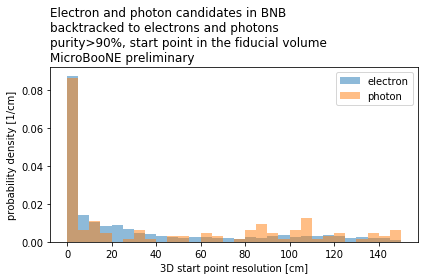

In [19]:
def base_selection_for_res_start_study(array):
    return (array['backtracked_purity'] > 0.9) &\
           (array['start_is_fiducial']) &\
           (array['backtracked_e'] > 1) &\
           ((abs(array['backtracked_pdg']) == 11) | (abs(array['backtracked_pdg']) == 22))

base_sel = base_selection_for_res_start_study(array_train)
plt.hist(array_train['distance_3d_start'][electron_train & base_sel], bins=30, range=[0, 150], alpha=0.5, density=True, label='electron')
plt.hist(array_train['distance_3d_start'][photon_train & base_sel], bins=30, range=[0, 150], alpha=0.5, density=True, label='photon')
plt.legend()
plt.xlabel('3D start point resolution [cm]')
plt.ylabel('probability density [1/cm]')
plt.title('Electron and photon candidates in BNB\nbacktracked to electrons and photons\npurity>90%, start point in the fiducial volume\nMicroBooNE preliminary', loc='left')
plt.tight_layout()
plt.savefig(save_folder_base + 'electron_photon_startpoint_res.png', dpi=250)
plt.savefig(save_folder_base + 'electron_photon_startpoint_res.pdf')

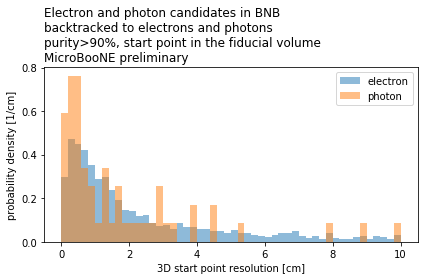

In [20]:
def base_selection_for_res_start_study(array):
    return (array['backtracked_purity'] > 0.9) &\
           (array['start_is_fiducial']) &\
           (array['backtracked_e'] > 1) &\
           ((abs(array['backtracked_pdg']) == 11) | (abs(array['backtracked_pdg']) == 22))

base_sel = base_selection_for_res_start_study(array_train)
plt.hist(array_train['distance_3d_start'][electron_train & base_sel], bins=50, range=[0, 10], alpha=0.5, density=True, label='electron')
plt.hist(array_train['distance_3d_start'][photon_train & base_sel], bins=50, range=[0, 10], alpha=0.5, density=True, label='photon')
plt.legend()
plt.xlabel('3D start point resolution [cm]')
plt.ylabel('probability density [1/cm]')
plt.title('Electron and photon candidates in BNB\nbacktracked to electrons and photons\npurity>90%, start point in the fiducial volume\nMicroBooNE preliminary', loc='left')
plt.tight_layout()
plt.savefig(save_folder_base + 'electron_photon_startpoint_res_zoom.png', dpi=250)
plt.savefig(save_folder_base + 'electron_photon_startpoint_res_zoom.pdf')

In [ ]:
plt.hist(array_train['backtracked_e'][electron_train & selection_train], bins=50, range=[0, 2], alpha=0.5, density=True, label='electron')
plt.hist(array_train['backtracked_e'][photon_train & selection_train], bins=50, range=[0, 2], alpha=0.5, density=True, label='photon')
plt.legend()
plt.xlabel('True shower energy [GeV]')
plt.ylabel('probability density [1/GeV]')
plt.title('Electron and photon candidates in BNB\nbacktracked to electrons and photons\npurity>90%, start point in the fiducial volume\nstart point accuracy < 2 cm\nMicroBooNE preliminary', loc='left')
plt.tight_layout()
plt.savefig(save_folder_base + 'electron_photon_shower_energy.png', dpi=250)
plt.savefig(save_folder_base + 'electron_photon_shower_energy.pdf')

In [ ]:
dedx_y = array_train['dedx_y'][photon_train & selection_train]
dist = array_train['dist_from_start_y'][photon_train & selection_train]

plt.hist2d(dist.flatten(), dedx_y.flatten(), range=[[0, 20], [0, 6]], bins=[51, 51])
plt.xlabel("Distance from the reco start point [cm]")
plt.ylabel("dE/dx [MeV/cm]")
plt.title('Photon candidates in BNB\nbacktracked to photons\npurity>90%, start point in the fiducial volume\nstart point accuracy < 2 cm\nMicroBooNE preliminary', loc='left')
plt.tight_layout()
plt.savefig(save_folder_base + 'photon_2d_dedx_dist.png', dpi=250)
plt.savefig(save_folder_base + 'photon_2d_dedx_dist.pdf')

In [ ]:
sh_energy_bins = [0, 0.1, 0.2, 1]
for sh_en_low, sh_en_high in zip(sh_energy_bins[:-1], sh_energy_bins[1:]):
    sh_en_mask = (array_train['backtracked_e'] > sh_en_low) & (array_train['backtracked_e'] <= sh_en_high)
    dedx_y = array_train['dedx_y'][photon_train & selection_train & sh_en_mask]
    dist = array_train['dist_from_start_y'][photon_train & selection_train & sh_en_mask]
    
    plt.hist2d(dist.flatten(), dedx_y.flatten(), range=[[0, 20], [0, 6]], bins=[51, 51])
    plt.xlabel("Distance from the reco start point [cm]")
    plt.ylabel("dE/dx [MeV/cm]")
    plt.title('Photon candidates in BNB\nbacktracked to photons with {:.2g} < E-true < {:.2g} GeV\npurity>90%, start point in the fiducial volume\nstart point accuracy < 2 cm\nMicroBooNE preliminary'
              .format(sh_en_low, sh_en_high), loc='left')
    plt.tight_layout()
    plt.savefig(save_folder_base + 'photon_2d_dedx_dist_sh_energy_{:.2f}_{:.2f}'.format(sh_en_low, sh_en_high).replace('.', '')+'.png', dpi=250)    
    plt.savefig(save_folder_base + 'photon_2d_dedx_dist_sh_energy_{:.2f}_{:.2f}'.format(sh_en_low, sh_en_high).replace('.', '')+'.pdf')

In [ ]:
sh_energy_bins = [0, 0.1, 0.2, 1]
for sh_en_low, sh_en_high in zip(sh_energy_bins[:-1], sh_energy_bins[1:]):
    sh_en_mask = (array_train['backtracked_e'] > sh_en_low) & (array_train['backtracked_e'] <= sh_en_high)
    dist_mask = array_train['dist_from_start_y'] < 4
    dedx_y = array_train['dedx_y'][photon_train & selection_train & dist_mask & sh_en_mask]
    
    plt.hist(dedx_y.flatten(), 
             range=[0, 6], 
             bins=51, 
             density=True,
             histtype='step',
             label='{:.2g} < E-true < {:.2g} GeV'.format(sh_en_low, sh_en_high))
    
plt.ylabel("probability density [1/(MeV/cm)]")
plt.xlabel("hit dE/dx in the first 4 cm [MeV/cm]")
plt.legend()
plt.ylim(0, 1)
plt.title('Photon candidates in BNB\nbacktracked to photons with \npurity>90%, start point in the fiducial volume\nstart point accuracy < 2 cm\nMicroBooNE preliminary', loc='left')
plt.tight_layout()
plt.savefig(save_folder_base + 'photon_1d_dedx_sh_energy.png', dpi=250)
plt.savefig(save_folder_base + 'photon_1d_dedx_sh_energy.pdf')

In [19]:
total_mask = photon_train & selection_train

for i_pl, plane in enumerate(['_u', '_v', '_y']):
    dedx = array_train['dedx_median_4'+plane][total_mask]
    sh_en = array_train['backtracked_e'][total_mask]

    plt.hist2d(sh_en.flatten(), dedx.flatten(), range=[[0, 0.5], [0, 6]], bins=[51, 51])
    plt.xlabel("True shower energy [GeV]")
    plt.ylabel("Median dE/dx in the first 4 cm [MeV/cm]")
    plt.title('Photon candidates in BNB, backtracked to photons\npurity>90%, start point in the fiducial volume\nstart point accuracy < 2 cm\nPlane {}\nMicroBooNE preliminary'.format(i_pl),
              loc='left')
    plt.tight_layout()
    plt.savefig(save_folder_base + 'plane{}_photon_2d_median_dedx_sh_energy.png'.format(i_pl), dpi=250)    
    plt.savefig(save_folder_base + 'plane{}_photon_2d_median_dedx_sh_energy.pdf'.format(i_pl))
    plt.close()

In [20]:
base_mask = photon_train & selection_train

for i_pl, plane in enumerate(['_u', '_v', '_y']):
    dist_mask = array_train['dist_from_start'+plane] < 4
    total_mask = base_mask & dist_mask
    dedx = array_train['dedx'+plane][total_mask]
    sh_en_expanded = array_train['backtracked_e'] * (array_train['dedx'+plane] == array_train['dedx'+plane])
#     import pdb; pdb.set_trace();
    sh_en = sh_en_expanded[total_mask]

    plt.hist2d(sh_en.flatten(), dedx.flatten(), range=[[0, 0.5], [0, 6]], bins=[51, 51])
    plt.xlabel("True shower energy [GeV]")
    plt.ylabel("Hit dE/dx in the first 4 cm [MeV/cm]")
    plt.title('Photon candidates in BNB, backtracked to photons\npurity>90%, start point in the fiducial volume\nstart point accuracy < 2 cm\nPlane {}\nMicroBooNE preliminary'.format(i_pl),
              loc='left')
    plt.tight_layout()
    plt.savefig(save_folder_base + 'plane{}_photon_2d_dedx_sh_energy.png'.format(i_pl), dpi=250)    
    plt.savefig(save_folder_base + 'plane{}_photon_2d_dedx_sh_energy.pdf'.format(i_pl))
    plt.close()

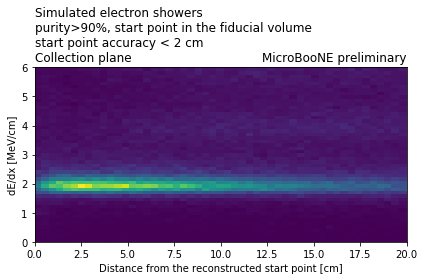

In [23]:
dedx_y = array_train['dedx_y'][electron_train & selection_train]
dist = array_train['dist_from_start_y'][electron_train & selection_train]

plt.hist2d(dist.flatten(), dedx_y.flatten(), range=[[0, 20], [0, 6]], bins=[51, 51])
plt.xlabel("Distance from the reconstructed start point [cm]")
plt.ylabel("dE/dx [MeV/cm]")
plt.title('Simulated electron showers\npurity>90%, start point in the fiducial volume\nstart point accuracy < 2 cm\nCollection plane', loc='left')
plt.title('MicroBooNE preliminary', loc='right')
plt.tight_layout()
plt.savefig(save_folder_base + 'electron_2d_dedx_dist.png', dpi=250)
plt.savefig(save_folder_base + 'electron_2d_dedx_dist.pdf')

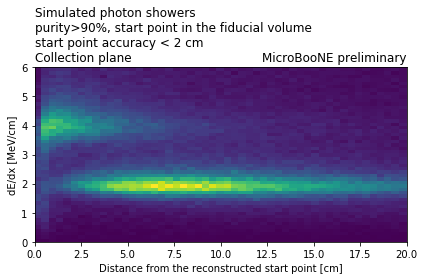

In [24]:
dedx_y = array_train['dedx_y'][photon_train & selection_train]
dist = array_train['dist_from_start_y'][photon_train & selection_train]

plt.hist2d(dist.flatten(), dedx_y.flatten(), range=[[0, 20], [0, 6]], bins=[51, 51])
plt.xlabel("Distance from the reconstructed start point [cm]")
plt.ylabel("dE/dx [MeV/cm]")
plt.title('Simulated photon showers\npurity>90%, start point in the fiducial volume\nstart point accuracy < 2 cm\nCollection plane', loc='left')
plt.title('MicroBooNE preliminary', loc='right')
plt.tight_layout()
plt.savefig(save_folder_base + 'photon_2d_dedx_dist.png', dpi=250)
plt.savefig(save_folder_base + 'photon_2d_dedx_dist.pdf')

[0.2 0.  0.2 ... 0.  0.  0. ]
[[0.2 0.2 0.2 ... 0.2 0.2 0.2] [] [] ... [] [0.0] []]

[0.2 0.2 0.2 ... 1.  1.  1. ]


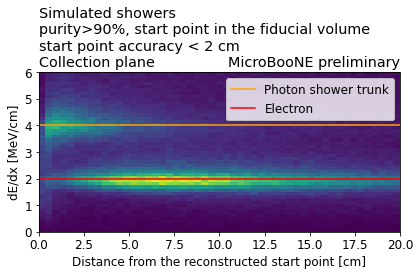

In [30]:
dedx_y = array_train['dedx_y'][selection_train]
dist = array_train['dist_from_start_y'][selection_train]

weights = 1.*(array_train['backtracked_pdg'] == 22) + 0.2*(np.abs(array_train['backtracked_pdg']) == 11)
print(weights)
weights = weights * (array_train['dedx_y'] == array_train['dedx_y'])
print(weights)
print()
weights = weights[selection_train].flatten()
print(weights)
    
plt.hist2d(dist.flatten(), dedx_y.flatten(), range=[[0, 20], [0, 6]], bins=[51, 51], weights=weights)
plt.xlabel("Distance from the reconstructed start point [cm]")
plt.ylabel("dE/dx [MeV/cm]")
plt.title('Simulated showers\npurity>90%, start point in the fiducial volume\nstart point accuracy < 2 cm\nCollection plane', loc='left')
plt.title('MicroBooNE preliminary', loc='right')

range_v = np.linspace(0, 20, 40)
plt.plot(range_v, 4*np.ones(range_v.shape), color='orange', label='Photon shower trunk')
plt.plot(range_v, 2*np.ones(range_v.shape), color='red', label='Electron')
plt.legend()
plt.tight_layout()
plt.savefig(save_folder_base + 'neutrino2020_shower_2d_dedx_dist.png', dpi=250)
plt.savefig(save_folder_base + 'neutrino2020_shower_2d_dedx_dist.pdf')

## Lookup Tables

In [ ]:
# two parameters
parameters_names = ['dist_from_start', 'pitch']
parameters_bin_edges = [[0., 1, 2, 3, 4, 5, 10, 100],
                  [0.3, 0.6, 1., 1.5, 3, 3000]]

dedx_var = 'dedx'
dedx_bins = [0.        , 0.31578947, 0.63157895, 0.94736842, 1.26315789,
       1.57894737, 1.89473684, 2.21052632, 2.52631579, 2.84210526,
       3.15789474, 3.47368421, 3.78947368, 4.10526316, 4.42105263,
       4.73684211, 5.05263158, 5.36842105, 5.68421053, 6. , 6.5, 7, 7.5, 8, 9, 10, 12, 15, 20, 30, 50]

parameters = []
dedx_vars = []
for plane in ['u', 'v', 'y']:
    parameters.append([parameter_name+'_'+plane for parameter_name in parameters_names])
    dedx_vars.append(dedx_var+'_'+plane)

pdgcode_var = 'backtracked_pdg'

In [ ]:
# declaring caloLikelihood objects
caloLike_train = caloLikelihood(array_train, quality_mask=selection_train, quality_masks_planes=selection_train_planes)
caloLike_test = caloLikelihood(array_test, quality_mask=selection_test, quality_masks_planes=selection_test_planes)

caloLike_train.setPdgCodeVar(pdgcode_var)
caloLike_test.setPdgCodeVar(pdgcode_var)

In [ ]:
for i in [0, 1, 2]:
    caloLike_train.setVariablesBinning(i, parameters[i], parameters_bin_edges, dedx_vars[i], dedx_bins)
    caloLike_train.buildLookUpTableMC(i, 11)    
    caloLike_train.buildLookUpTableMC(i, 22)    
    caloLike_train.buildLookUpLogLikelihoodRatio(i, [11, 22])
    caloLike_test.setVariablesBinning(i, parameters[i], parameters_bin_edges, dedx_vars[i], dedx_bins)

In [ ]:
caloLike_train.addCalorimetryVariables(caloLike_test.array, pdg_codes=[11, 22])
caloLike_train.addCalorimetryVariablesFromLLRTable(caloLike_test.array)

In [ ]:
caloLike_train.printCplusplusLookUp(filename='/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/larsoft_dev/LLRPID_electron_photon_lookup_new.h', 
                                    name='ELECTRON_PHOTON', struct_name='ElectronPhotonLookUpParameters',
                                    planes=[0, 1, 2])

## Plot of the pdfs/likelihoods in bins of residual range and pitch

### Plot PDFs from lookup tables

In [ ]:
# Plot PDF 2parameters
for plane_num in [0, 1, 2]:
    bin_centers = product(*caloLike_train.parameters_bin_centers[plane_num])
    for bin_center in bin_centers:
        caloLike_train.plotLookUpDedxMC(plane_num=plane_num, 
                                  pdg_code=11, 
                                  parameters_value=bin_center, 
                                  label='electron',
                                  axis_label='dedx')
        caloLike_train.plotLookUpDedxMCfancy(plane_num=plane_num, 
                                  pdg_code=22, 
                                  parameters_value=bin_center, 
                                  label='photon',
                                  axis_label='dedx')
        plt.xlim(0, 10)
        plt.ylim(bottom=0)
        plt.tight_layout()
        plt.savefig(save_folder_pdfs+'plane{}/dist_{:.2f}_pitch_{:.2f}'.format(plane_num, bin_center[0], bin_center[1]).replace('.', '')+'.png', dpi=250)
        plt.savefig(save_folder_pdfs+'plane{}/dist_{:.2f}_pitch_{:.2f}'.format(plane_num, bin_center[0], bin_center[1]).replace('.', '')+'.pdf')
        plt.close()

## Plots

In [ ]:
sel = selection_test & (electron_test | photon_test)
(array_test['dedx_median_4_y'][sel]<0).sum()/len(array_test['dedx_median_4_y'][sel])

In [ ]:
interesting_variables = [
                         'dedx_median_4_u',
                         'dedx_median_4_v',
                         'dedx_median_4_y',
                         'llr_sum_0',
                         'llr_sum_1',
                         'llr_sum_2',
                         'llr_01',
                         'llr_012',
                        ]

variable_labels = {
    'dedx_median_4_u': 'dE/dx U median-4cm',
    'dedx_median_4_v': 'dE/dx V median-4cm',
    'dedx_median_4_y': 'dE/dx Y median-4cm',
    'llr_sum_0': 'LLR U',
    'llr_sum_1': 'LLR V',
    'llr_sum_2': 'LLR Y',
    'llr_01': 'LLR UV',   
    'llr_012': 'LLR UVY',   
}

for variable in interesting_variables:
    if 'llr' in variable:
        scale = 10
    elif 'bragg' in variable:
        scale = 1
    else:
        scale = 10
    add_norm_variable(caloLike_test.array, variable, scale)

In [ ]:
bins = 101
hist_range = [-1, 1]
kwargs = {'histtype':'step'}
for var in interesting_variables:
    variable = var + '_n'
    caloLike_test.plotVariableMC(variable, bins, hist_range, function_mask=electron_for_test, quality_mask=True, label='electron', **kwargs);
    caloLike_test.plotVariableMCFancy(variable, bins, hist_range, function_mask=photon_for_test, quality_mask=True, label='photon', **kwargs);
    plt.xlabel(variable_labels[var])
    plt.tight_layout()
    plt.savefig(save_folder_performance + variable + '.png', dpi=250)
    plt.savefig(save_folder_performance + variable + '.pdf')
    plt.close()

In [ ]:
def electron_selection_function(array, parameter, bin_range):
    return (array[parameter] >= bin_range[0]) &\
           (array[parameter] < bin_range[1]) &\
            electron_for_test(array)

def photon_selection_function(array, parameter, bin_range):
    return (array[parameter] >= bin_range[0]) &\
           (array[parameter] < bin_range[1]) &\
            photon_for_test(array)

pdg_codes = [11, 22]
interesting_variables = [
#                          'dedx_median_4_u',
#                          'dedx_median_4_v',
                         'dedx_median_4_y',
#                          'llr_sum_0',
#                          'llr_sum_1',
                         'llr_sum_2',
                         'llr_01',
                         'llr_012',
                        ]
parameter_name = 'backtracked_e'
parameter_bin_edges = np.array([0.0, 0.1, 0.2, 1, 2])

bins = 101
hist_range = [-1, 1]
kwargs = {'histtype':'step'}
for sh_en_bin in zip(parameter_bin_edges[:-1], parameter_bin_edges[1:]):
    for var in interesting_variables:
        def this_electron_function(array):
            return electron_selection_function(array, parameter_name, sh_en_bin)
        def this_photon_function(array):
            return photon_selection_function(array, parameter_name, sh_en_bin)
        
        variable = var + '_n'
        caloLike_test.plotVariableMC(variable, bins, hist_range, function_mask=this_electron_function, quality_mask=True, label='electron', **kwargs);
        caloLike_test.plotVariableMCFancy(variable, bins, hist_range, function_mask=this_photon_function, quality_mask=True, label='photon', 
                                          add_to_title='\n{:.2g} < E-true < {:.2g} GeV'.format(sh_en_bin[0], sh_en_bin[1]), **kwargs);
        plt.xlabel(variable_labels[var])
        plt.tight_layout()
        plt.savefig(save_folder_performance + variable + '_sh_energy_{:.2f}_{:.2f}'.format(sh_en_bin[0], sh_en_bin[1]).replace('.', '')+'.png', dpi=250)
        plt.savefig(save_folder_performance + variable + '_sh_energy_{:.2f}_{:.2f}'.format(sh_en_bin[0], sh_en_bin[1]).replace('.', '')+'.pdf')
        plt.close()

## ROC curves

In [ ]:
interesting_variables = [
#                          'dedx_median_4_u',
#                          'dedx_median_4_v',
                         'dedx_median_4_y',
#                          'llr_sum_0',
#                          'llr_sum_1',
                         'llr_sum_2',
                         'llr_01',
                         'llr_012',
                        ]

for variable in interesting_variables:
    caloLike_test.rocCurve(variable=variable+'_n', 
         pdg_codes=[11, 22], 
         plot=True,
         variable_label=variable_labels[variable])

plt.title('Electron/photon separation\nSimulated tracks', loc='left')
plt.savefig(save_folder_performance + 'roc_curves.png', dpi=250)
plt.savefig(save_folder_performance + 'roc_curves.pdf')

In [ ]:
def selection_function(array, parameter, bin_range):
    return (array[parameter] >= bin_range[0]) &\
           (array[parameter] < bin_range[1])

pdg_codes = [11, 22]
interesting_variables = [
#                          'dedx_median_4_u',
#                          'dedx_median_4_v',
                         'dedx_median_4_y',
#                          'llr_sum_0',
#                          'llr_sum_1',
                         'llr_sum_2',
                         'llr_01',
                         'llr_012',
                        ]
parameter_name = 'backtracked_e'
parameter_bin_edges = np.array([0, 0.1, 0.2, 0.5, 1, 1.5, 2])

for variable in interesting_variables:
    out = caloLike_test.auc1D(variable+'_n', 
                        pdg_codes, 
                        selection_function, 
                        parameter_name, 
                        parameter_bin_edges,
                        legend_label=variable_labels[variable])
plt.ylim(0.5, 1)
plt.xlabel(r'True shower energy [GeV]')
plt.legend()
plt.title('Electron/photon separation\nSimulated tracks', loc='left')
plt.tight_layout()
plt.savefig(save_folder_performance+'auc1d_'+parameter_name+'.png', dpi=250)
plt.savefig(save_folder_performance+'auc1d_'+parameter_name+'.pdf')